## Imports and Cleaning

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from data_clean import *
from viz_helper import *
%load_ext autoreload
%autoreload 10

### Live data
For this project, data is read in live from Johns Hopkins CSSE, the New York Times, and the Covid Tracking Project (associated with The Atlantic). The update times for each source differ across the sources, but are typically fully updated by the next day. 
Their sources, on the other hand, are from a collection of government agencies for international cases, and often state health department websites for county and state level information. The COVID Tracking Project provides a grade for each state depending on the reliability of testing data: https://covidtracking.com/about-data.
For quick dashboards, check out the Hopkins CSSE dash: https://coronavirus.jhu.edu/map.html.


In [ ]:
# Countries from Johns Hopkins, State & Local from NYT, and Testing from the Covid Tracking Project
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



In [5]:
# Quick list of dates when US states entered into some form of containment or lockdown
containment = pd.read_csv('containment.txt')
containment.columns = ['State', 'Date']
containment = containment.sort_values(by='Date').groupby(by='State').agg('last').reset_index()
containment.sample(5)

,State,Date
17,Maine,2020-03-26
10,Hawaii,2020-03-25
20,Michigan,2020-03-24
15,Kentucky,2020-03-27
40,West Virginia,2020-03-25


In [6]:
df_country[df_country.Country.isin(['US'])].tail()

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
12980,US,2020-04-01,213372,2020-01-22,71,25200.0,4.262680,12.270792,10.134599
13163,US,2020-04-02,243453,2020-01-22,72,30081.0,4.276666,12.402679,10.311649
13346,US,2020-04-03,275586,2020-01-22,73,32133.0,4.290459,12.526655,10.377639
13529,US,2020-04-04,308850,2020-01-22,74,33264.0,4.304065,12.640611,10.412231
13712,US,2020-04-05,337072,2020-01-22,75,28222.0,4.317488,12.728052,10.247857


In [7]:
df_local[df_local.County=='Albemarle'].tail()

,County,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
413,Albemarle,Virginia,2020-03-31,21,2020-03-07,25,2.0,3.218876,3.044522,0.693147
414,Albemarle,Virginia,2020-04-01,21,2020-03-07,26,0.0,3.258097,3.044522,-inf
415,Albemarle,Virginia,2020-04-02,23,2020-03-07,27,2.0,3.295837,3.135494,0.693147
416,Albemarle,Virginia,2020-04-03,26,2020-03-07,28,3.0,3.332205,3.258097,1.098612
417,Albemarle,Virginia,2020-04-04,27,2020-03-07,29,1.0,3.367296,3.295837,0.000000


In [8]:
# NYT aggregated state counts have recently been higher than the daily reports from Hopkins
pd.DataFrame(df_state.groupby('Date').sum().Confirmed - df_country[df_country.Country=='US'].groupby('Date').sum().Confirmed).dropna().tail(7)

,Confirmed
Date,
2020-03-29,1308.0
2020-03-30,1876.0
2020-03-31,-123.0
2020-04-01,1339.0
2020-04-02,775.0
2020-04-03,796.0
2020-04-04,2686.0


## Are we flattening the curve?

### New confirmed cases vs cumulatative cases

For an exponential growth function, the slope of the curve, or daily increase in cases should remain proportional to the total number of cases in a given region. With that expectation, we would expect regions experiencing exponential growth to exhibit linearity when plotting log of new cases against log of current cases. Countries that have moved past this plateau, such as South Korea and China (as of 4/05), should taper off, as described in the following video by Henry Reich and Aashish B: https://www.youtube.com/watch?v=54XLXg4fYsc

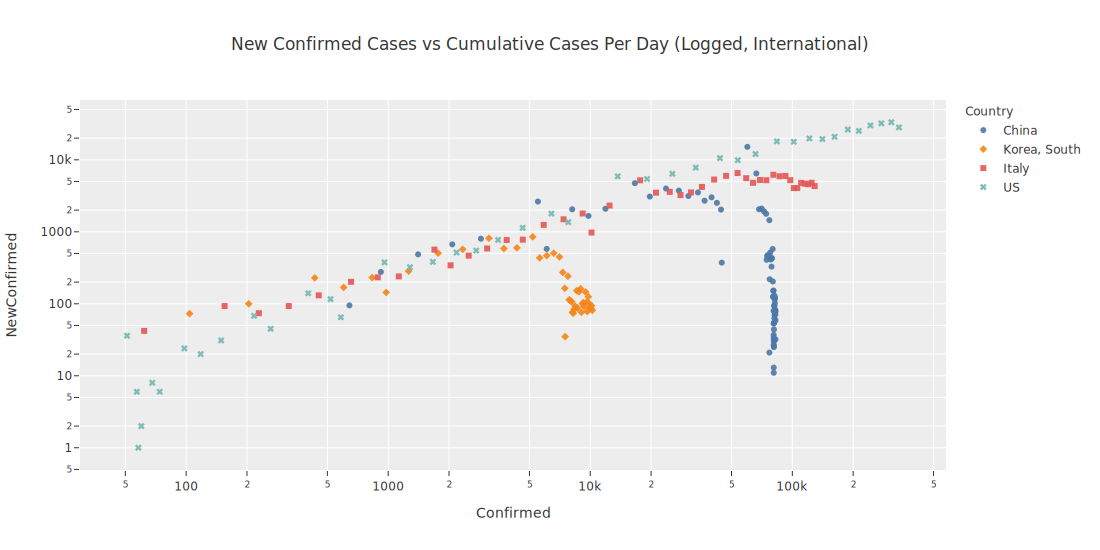

In [35]:
# Appears that China and South Korea have defintely been able to "flatten" the curve, while Italy is nearing the end of the tunnel. 
countriesToPlot = ['US', 'Korea, South', 'Italy', 'China']
fig =   px.scatter(data_frame=df_country[df_country.Country.isin(countriesToPlot)].loc[df_country.Confirmed > 50], 
                   x='Confirmed', y='NewConfirmed', color='Country', symbol='Country',
                   log_x=True,log_y=True, 
                   hover_name='Date', hover_data=['NewConfirmed','Confirmed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, International)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, opacity=0.9
                  )
fig.show(renderer='svg', width=1100, height=550)

In [37]:
# To Do: Animated scatter against date

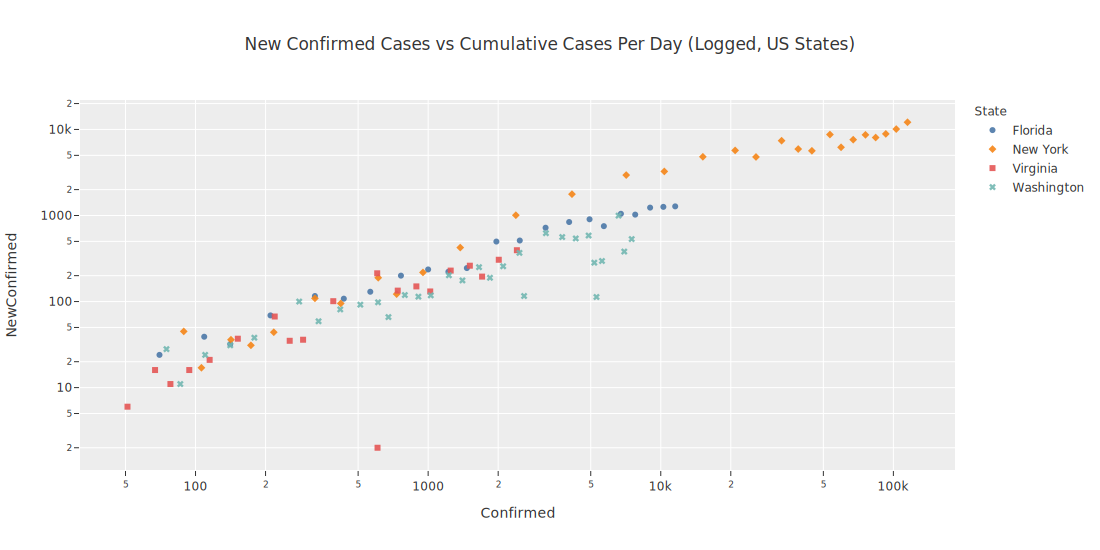

In [33]:
# Conducting a similar analysis applied towards US states:
statesToPlot = ['New York', 'Washington', 'Lousiana', 'Virginia', 'Florida']
fig =   px.scatter(data_frame=df_state[df_state.State.isin(statesToPlot)].loc[df_state.Confirmed>50], 
                   x='Confirmed', y='NewConfirmed', color='State', symbol='State',
                   log_x=True,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                   hover_name='Date', hover_data=['State','DaysElapsed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, US States)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, opacity=0.9
#                    color_continuous_scale='Teal_r', 
                  )
fig.update(layout_coloraxis_showscale=False)
fig.show(renderer='svg', width=1100, height=550)

## Some time series plots

### Confirmed cases in US States with governor lockdown measures 
Containment is a critical measure in reducing effective reproductive number of the virus. Most early-stage growth models can be viewed as a piecewise composition of a basic reproduction number ($R_0$) and a second effective reproduction number($R_e$). A team at the University of Toronto has a great article and corresponding dashboard explaining this concept: https://annals.org/aim/fullarticle/2760912/reporting-epidemic-growth-reproduction-numbers-2019-novel-coronavirus-2019-ncov. 
US states have undergone containment measures in different timelines. Assuming a delay comprised of a biological incubation, delay for testing & recording, we can expect to see tangible changes to ($R_e$) roughly two weeks post.

New York entered containment on 2020-03-23
New Jersey entered containment on 2020-03-22
Washington entered containment on 2020-03-23
Virginia entered containment on 2020-03-30


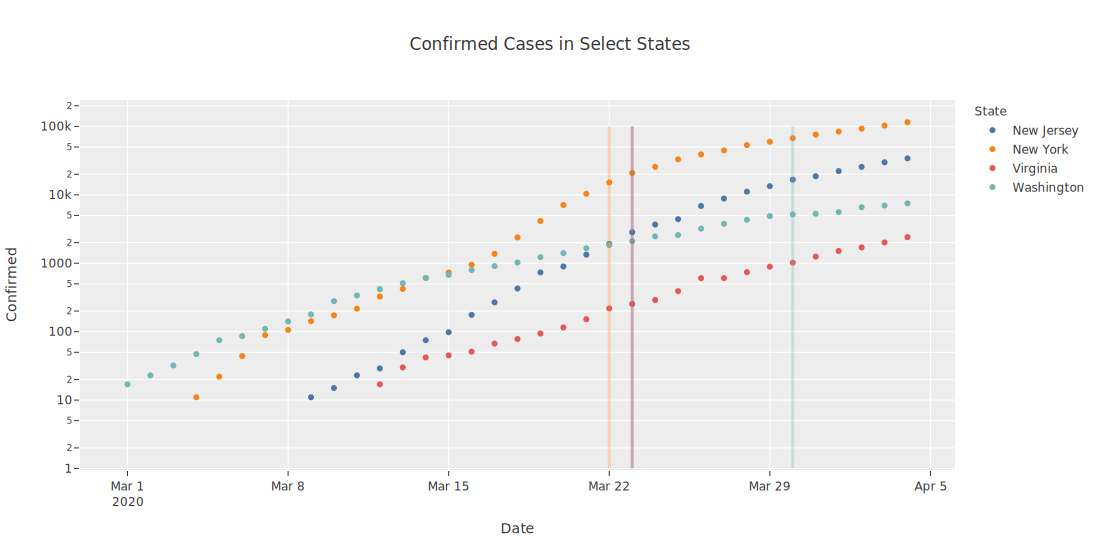

In [47]:
states = ['New York', 'New Jersey', 'Washington', 'Virginia']
fig =px.scatter(data_frame=df_state[df_state.State.isin(states)].loc[df_state.Confirmed > 10], 
                x='Date', y='Confirmed', color='State',
                log_x=False,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                hover_name='Date', hover_data=['NewConfirmed','Confirmed','DaysElapsed'],
                title='Confirmed Cases in Select States', template='ggplot2', 
                color_discrete_sequence=px.colors.qualitative.T10,
               )

c = 0
for s in states:
    containment_date = containment[containment.State==s].Date.values[0]
    fig.add_shape(dict(type="line", 
                       x0=containment_date, y0=1, x1=containment_date, y1=100000, 
                       line=dict(color=px.colors.qualitative.T10[c],
                                 width=3, dash='solid'
                                )))
    c += 1
    print('{} entered containment on {}'.format(s, containment_date))
    
fig.update_shapes(dict(xref='x', yref='y'))

fig.show(renderer='svg', width=1100, height=550)

## Testing, testing, testing 

### Tests vs. Cases
As seen in the Wall Street Journal: https://www.wsj.com/articles/how-the-cdcs-restrictive-testing-guidelines-hid-the-coronavirus-epidemic-11584882001.


In [58]:
df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index()

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
0,AK,2020-04-05,185.0,6099.0,13.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,6.0,20.0,6284,6284,6284,1.0,4.0,230.0,14.0,244.0
1,AL,2020-04-05,1796.0,11282.0,40.0,NaN,231.0,NaN,NaN,NaN,NaN,NaN,45.0,231.0,13078,13078,13078,2.0,19.0,2009.0,216.0,2225.0
2,AR,2020-04-05,830.0,10412.0,0.0,67.0,130.0,NaN,43.0,27.0,39.0,97.0,16.0,130.0,11242,11242,11242,2.0,130.0,785.0,87.0,872.0
3,AS,2020-04-05,0.0,20.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,26,20,20,0.0,0.0,0.0,0.0,0.0
4,AZ,2020-04-05,2269.0,25141.0,21.0,NaN,310.0,NaN,108.0,NaN,NaN,NaN,64.0,310.0,27410,27410,27410,12.0,13.0,0.0,250.0,250.0
5,CA,2020-04-05,13438.0,103095.0,15000.0,2398.0,1855.0,1040.0,774.0,NaN,NaN,NaN,319.0,1855.0,131533,116533,116533,43.0,0.0,1421.0,1412.0,2833.0
6,CO,2020-04-05,4565.0,19335.0,1.0,NaN,875.0,NaN,NaN,NaN,NaN,NaN,126.0,875.0,23900,23900,23900,15.0,52.0,1437.0,392.0,1829.0
7,CT,2020-04-05,5675.0,17595.0,8.0,1142.0,766.0,NaN,NaN,NaN,NaN,NaN,189.0,766.0,23270,23270,23270,24.0,0.0,842.0,399.0,1241.0
8,DC,2020-04-05,998.0,5836.0,2.0,NaN,NaN,NaN,NaN,193.0,193.0,258.0,22.0,NaN,6834,6834,6834,1.0,0.0,300.0,96.0,396.0
9,DE,2020-04-05,673.0,6321.0,32.0,101.0,57.0,NaN,NaN,NaN,NaN,71.0,14.0,57.0,6994,6994,6994,0.0,0.0,447.0,80.0,527.0


In [61]:
fig = px.scatter(data_frame=df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index(),
                 x='Total', y='Positive', color='State',
                 log_x=True, log_y=True,
                )
fig.show()

## Geographic distribution of cases

In [38]:
# px.choropleth(data_frame=df_country[df_country.Country.isin(['US', 'Korea, South', 'Italy'])],
#               lat='Lat', lon='Long',
#              )